The Slew rate for a pulse is defined as
$$
\text{Slew rate} = \max_{t\in [0,t_\text{f}]} \left(\frac{dV}{dt}\right)\propto \max_{t\in [0,t_\text{f}]} \left(\frac{d\lambda}{dt}\right),
$$
where $\lambda(t)$ is the driving parameters. In the case of the LZ problem, we can obtain the analytical result for the Slew rate as
$$
\text{Slew rate} \propto \frac{2^{\alpha/2}\delta^{(\alpha,\beta)}}{x^{\beta/2}}\max_{t\in [0,t_\text{f}]} \left((x^2+z(t)^2)^{n_+/2}\right).
$$

Another importar property of a pulse is the bandwidth, defined as
$$
\text{Bandwidth} = f_\text{max}-f_\text{min}\Big|_{|\mathcal{F}(t, f)|\geq \mathcal{F}_\text{max}/\sqrt{2}}.
$$
where $\mathcal{F}(t, f)$ is the short time Fourier transform, which reads
$$
\mathcal{F}(t, f) = \int_{-\infty}^\infty dt \lambda(t)w(t)e^{-2\pi ift}.
$$
Here, $w(t)$ is the window function,for which we use a Hamming window function.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.parallel_utils import parameter_run

In [17]:
x = 1

n_values = 21  # Increase to enhance resolution

alphas = np.linspace(-5, 5, n_values) * 2
beta = 0
n_plus = (alphas + beta) / 2

zs_sol = parameter_run(solve_LZ, 'alpha', alphas, beta=0, x=x, n_s=2**20 + 1)

solve_LZ: [['alpha']]:   0%|          | 0/21 [00:00<?, ?it/s]

# Slew rate

In [18]:
s = np.linspace(0, 1, len(zs_sol[0]))
ds = np.abs(s[1] - s[0])

dz = np.gradient(zs_sol, ds, axis=1)
slew_rate = np.max(dz, axis=1)

In [19]:
def delta(alpha, beta, z):
    n_plus = (alpha + beta) / 2
    return sp.special.hyp2f1(1, (3 - n_plus) / 2, 3 / 2, -z ** 2 / x ** 2) * z * np.sqrt(2 ** -alpha * x ** beta * (x ** 2 + z ** 2) ** -n_plus) * (1 + z ** 2 / x ** 2)

analytic_1 = [2 ** (alpha / 2) * 2 * delta(alpha, beta, 10) * (1 ** 2 + 10 ** 2) ** ((alpha + beta) / 4) for alpha in alphas]
analytic_2 = [2 ** (alpha / 2) * 2 * delta(alpha, beta, 10) * (1 ** 2) ** ((alpha + beta) / 4) for alpha in alphas]

analytic_1 = np.array(analytic_1)
analytic_2 = np.array(analytic_2)

indices_negative = np.where(n_plus < 0)[0]

analytic_total = analytic_1
analytic_total[indices_negative] = analytic_2[indices_negative]

# Short time Fourier transform

In [20]:
def find_fmax(pulse, window, threshold=-20):
    boundary_left = np.ones(len(pulse)) * -10
    boundary_right = np.ones(len(pulse)) * 10

    pulse = np.concatenate((boundary_left, pulse, boundary_right))
    s = np.linspace(0, 3, len(pulse))

    SFT = sp.signal.ShortTimeFFT(window, hop=1, fs=1 / (s[1] - s[0]), scale_to='psd')
    Sx = SFT.stft(pulse)

    signal = np.abs(Sx)
    signal = 10 * np.log10(signal / np.max(signal))

    index_0 = np.where(s > 0.5)[0][0]
    index_f = np.where(s > 2.5)[0][0]

    signal = signal[:, index_0:index_f]
    indices = np.where(signal >= threshold)
    index_max = np.argmax(indices[0])

    freq = SFT.f
    time = SFT.t(len(pulse))
    
    return freq[indices[0][index_max]], time[index_0:index_f][indices[1][index_max]] - 1

In [21]:
threshold = -20
window = sp.signal.windows.hamming(5000)
reduction = 6

pulses_reduced = [pulse[::2 ** reduction] for pulse in zs_sol]
fs_max, ts_max = parameter_run(find_fmax, 'pulse', pulses_reduced, reshape=True, n_workers=3, threshold=threshold,
                               window=window)

find_fmax: [['pulse']]:   0%|          | 0/21 [00:00<?, ?it/s]

/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipykernel_25306/1191821124.py:12: RuntimeWarning: divide by zero encountered in log10
/var/folders/ft/m248tj8s21b0kgjh20yzzt1c0000gn/T/ipyker

# Plot

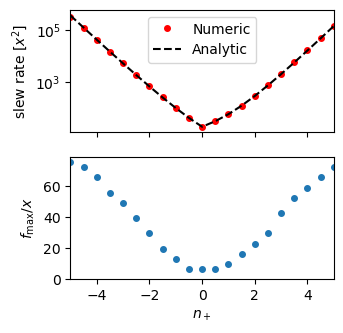

In [24]:
fig, axs= plt.subplots(2, 1, figsize=(3.4, 3.5), sharex=True)

# Slew rate (left)
axs[0].plot(n_plus, slew_rate, '.',
            markersize=8, label='Numeric', c='r')
y_limits = axs[0].get_ylim()

axs[0].plot(n_plus, analytic_total, '--', label=r'Analytic', c='k')

axs[0].legend()
axs[0].set_xlim(np.min(n_plus), np.max(n_plus))
axs[0].set_yscale('log')
axs[0].set_ylabel(r'slew rate $[x^2]$')

# STFT
axs[1].plot(n_plus, fs_max, '.', markersize=8)

axs[1].set_xlabel(r'$n_+$')
axs[1].set_ylabel(r'$f_\mathrm{max} / x$')
axs[1].set_xlim(min(n_plus), max(n_plus))
axs[1].set_ylim(0, None);